In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import RandomOverSampler
from keras.models import Sequential
from keras.layers import Input, Masking, Conv1D, MaxPooling1D, LSTM, Dropout, Dense
from keras.optimizers import Adam
from keras.utils import pad_sequences
from sklearn.decomposition import PCA

# Load the dataset
file_path = "/content/data.csv"
data = pd.read_csv(file_path)

X = data.drop(columns=["Bankrupt?"]).values
y = data["Bankrupt?"].values.astype("int64")  # Ensure the target is integer type

# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Use a Random Forest to compute feature importance
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# # Select features based on importance (e.g., top 10 features)
# n_features = 75  # Adjust this number as needed
# indices = np.argsort(importances)[-n_features:]  # Indices of top features
# X_selected = X[:, indices]

# # Print selected feature indices and their importance
# selected_features = pd.DataFrame({
#     "Feature Index": indices,
#     "Importance": importances[indices]
# }).sort_values(by="Importance", ascending=False)
# print(selected_features)

    Feature Index  Importance
74             89    0.038301
73             39    0.030795
72             18    0.028503
71             42    0.026108
70             36    0.021277
..            ...         ...
4              44    0.006740
3              73    0.006664
2              47    0.006620
1              40    0.006160
0              10    0.004186

[75 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_95' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_96' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'conv1d_97' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/ker

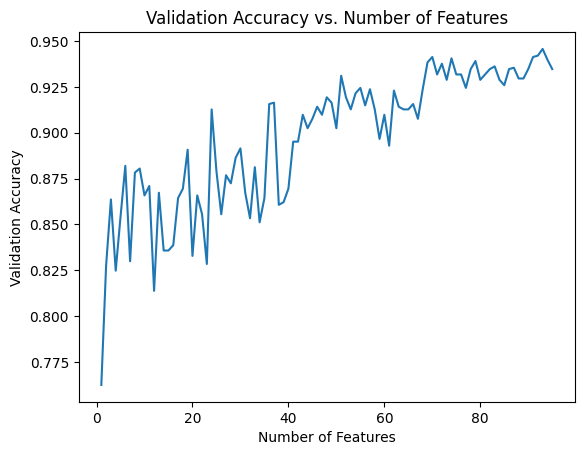

In [ ]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

sequence_length = 1

num_features_list = range(1, len(importances) + 1)
val_accuracies = []

for n_features in num_features_list:
    indices = np.argsort(importances)[-n_features:]
    X_selected = X[:, indices]

    # Convert X_selected into sequences
    X_grouped = [X_selected[i].reshape(sequence_length, n_features) for i in range(len(X))]
    X_padded = pad_sequences(X_grouped, maxlen=sequence_length, dtype='float32', padding='post', truncating='post')

    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X_padded, y, test_size=0.2, random_state=42)

    # Oversample training data
    X_train_2d = X_train.reshape(X_train.shape[0], -1)
    ros = RandomOverSampler(random_state=42)
    X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train_2d, y_train)

    # smote = SMOTE(random_state=42)
    # X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_2d, y_train)

    X_train_oversampled = X_train_oversampled.reshape(X_train_oversampled.shape[0], sequence_length, n_features)

    # Reshape validation data
    X_val = X_val.reshape(X_val.shape[0], sequence_length, n_features)

    # Train model
    model = Sequential([
        Input(shape=(sequence_length, n_features)),
        Masking(mask_value=0.0),
        Conv1D(64, 3, activation='relu', padding='same'),
        MaxPooling1D(pool_size=1),
        LSTM(128, return_sequences=True, activation='tanh'),
        Dropout(0.3),
        LSTM(64, return_sequences=False, activation='tanh'),
        Dropout(0.3),
        Dense(32, activation='relu'),
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_oversampled, y_train_oversampled, epochs=5, batch_size=32, verbose=0)  # Short epochs for testing

    # Evaluate and store validation accuracy
    val_loss, val_accuracy = model.evaluate(X_val, y_val, verbose=0)
    val_accuracies.append(val_accuracy)

plt.plot(num_features_list, val_accuracies)
plt.xlabel('Number of Features')
plt.ylabel('Validation Accuracy')
plt.title('Validation Accuracy vs. Number of Features')
plt.show()
